In [1]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd 
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn import decomposition
from seaborn import heatmap as hmap
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.patches import Ellipse

In [2]:
def dataload(files):
    col_idx = [5,6,7,8,9,10,11,14,15,16,17,18,19,22,23,24,26,27,28,29,30,31,32,33,34,36,37,38,39,40,41,42,43,44,45,52,53,54,55]
    dfl = pd.read_csv(files[0]).iloc[:, col_idx]
    dfr = pd.read_csv(files[1]).iloc[:, col_idx]
    intx = np.linspace(0,100, 50000)
    lx = np.linspace(0,100,dfl.shape[0])
    rx = np.linspace(0,100,dfr.shape[0])
    ly = dfl.to_numpy().T
    ry = dfr.to_numpy().T
    lint = interp1d(lx,ly,kind = 'linear')
    rint = interp1d(rx,ry,kind = 'linear')
    yintl = lint(intx).T
    yintr = rint(intx).T
    yout = np.concatenate((yintl,yintr), axis=1)
    ystand = np.zeros(np.shape(yout))
    for cid in range(np.shape(yout)[1]):
        ystand[:,cid] = preprocessing.scale(yout[:,cid])
    return ystand

In [3]:
filelist = pd.read_excel('filepairs.xlsx', index_col=0) 

In [4]:
inputdata = np.zeros([filelist.shape[0],50000,78])
for fid in range(filelist.shape[0]):
    inputdata[fid] = (dataload(filelist.iloc[fid]))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered w

In [5]:
print(np.shape(inputdata))

(106, 50000, 78)


In [6]:
def custom_pca(features,n_comp):
    pca = decomposition.PCA(n_components=n_comp)
    #temporal PC score by features
    temp_pc_score = np.zeros([np.shape(features)[0],np.shape(features)[2]])
    feat_pc_score = np.zeros([np.shape(features)[0],np.shape(features)[1]])
    for p in range(np.shape(features)[2]):
        idata = features[:,:,p]
        temp_pc_score[:,p] = pca.fit_transform(idata).T
    #feature PC score by time
    for q in range(np.shape(features)[1]):
        idata = features[:,q,:]
        feat_pc_score[:,q] = pca.fit_transform(idata).T
    return temp_pc_score, feat_pc_score

In [7]:
t_score, f_score = custom_pca(inputdata, 1)

In [8]:
print(np.shape(t_score))
print(np.shape(f_score))

(106, 78)
(106, 50000)


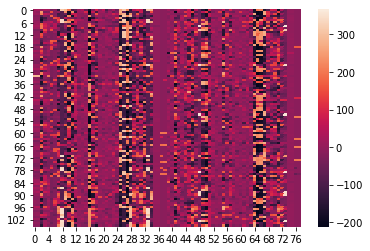

In [9]:
hmap(t_score)

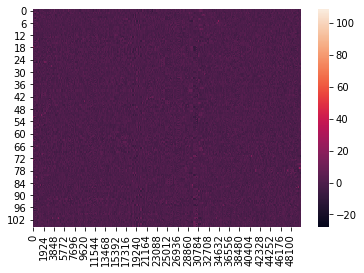

In [10]:
hmap(f_score)

In [11]:
def get_gmm_vals(gmm, X, data_dimension, number_of_gaussian, label=True, ax=None):
    pos_full = np.zeros((number_of_gaussian,data_dimension))
    covar_full = np.zeros((number_of_gaussian,data_dimension,data_dimension))
    labels = gmm.fit(X).predict(X)
    w_factor = 0.2 / gmm.weights_.max()
    i = 0
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        pos_full[i,:] = pos
        covar_full[i,:,:] = covar
        i = i+1
    return pos_full, covar_full

def get_gmm_labels(gmm, X, data_dimension, number_of_gaussian, label=True, ax=None):
    pos_full = np.zeros((number_of_gaussian,data_dimension))
    covar_full = np.zeros((number_of_gaussian,data_dimension,data_dimension))

    labels = gmm.fit(X).predict(X)
    return labels

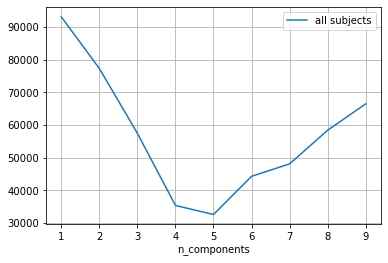

In [12]:
fit_data = t_score
n_components = np.arange(1, 10)
models = [GMM(n, covariance_type='full', random_state=0).fit(fit_data)
          for n in n_components]

plt.plot(n_components, [m.bic(fit_data) for m in models], label='BIC')
plt.legend(['all subjects'],loc='best')

plt.xlabel('n_components');
plt.grid()

In [17]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()    
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance) # SVD 사용 for PCA
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, facecolor= 'steelblue',**kwargs))
###################################################################

fit_data = t_score
fit_data = np.array(fit_data)
fit_data.shape

###################################################################
number_of_gaussian = 5
data_dimension = 78
gmm_lib= GMM(n_components=number_of_gaussian, covariance_type='full', random_state=0)
pos, covar = get_gmm_vals(gmm_lib, fit_data, data_dimension, number_of_gaussian, label=False)
labels = get_gmm_labels(gmm_lib, fit_data, data_dimension, number_of_gaussian, label=False)

centers = pos
model = gmm_lib
nor_labels = labels

In [18]:
center_full_nor = np.zeros((number_of_gaussian,data_dimension))
w_full_nor = np.zeros((number_of_gaussian,1))
i = 0
for pos, covar, w in zip(model.means_, model.covariances_, model.weights_):
    center_full_nor[i,:] = pos
    w_full_nor[i,:] = w
    i = i+1
    
print(np.transpose(round(pd.DataFrame(center_full_nor),2)))

        0      1      2      3      4
0   -2.15   0.59  11.86  -1.41  -9.87
1   -3.76   1.34  10.27   0.85 -11.82
2  -32.95  22.96 -43.76   6.85  17.84
3    5.48   1.20   3.93  12.83 -30.24
4   -4.19   6.70   5.41   1.16 -16.91
..    ...    ...    ...    ...    ...
73  31.63 -13.00 -32.25  51.64 -44.55
74   0.54  -0.50  -1.04  -0.98   3.13
75   0.84  -0.54  -1.59  -1.03   3.62
76 -13.57  -9.68  -0.68  -1.79  32.06
77 -10.47 -10.47  -0.01  -2.54  31.60

[78 rows x 5 columns]


In [19]:
print(labels)
print(labels.shape)

[2 4 3 2 3 0 1 1 1 2 1 2 2 2 1 1 1 2 4 4 1 4 1 4 4 1 3 3 1 2 1 3 2 1 3 2 4
 3 1 1 1 1 1 4 1 1 1 2 1 4 3 3 4 2 4 3 1 1 1 2 3 4 2 3 1 2 3 4 3 3 1 0 4 2
 4 1 3 0 0 3 2 3 3 3 3 3 1 0 4 3 3 3 1 2 1 4 3 0 0 0 0 0 1 0 0 0]
(106,)


Text(0.5, 0, 'feature 11')

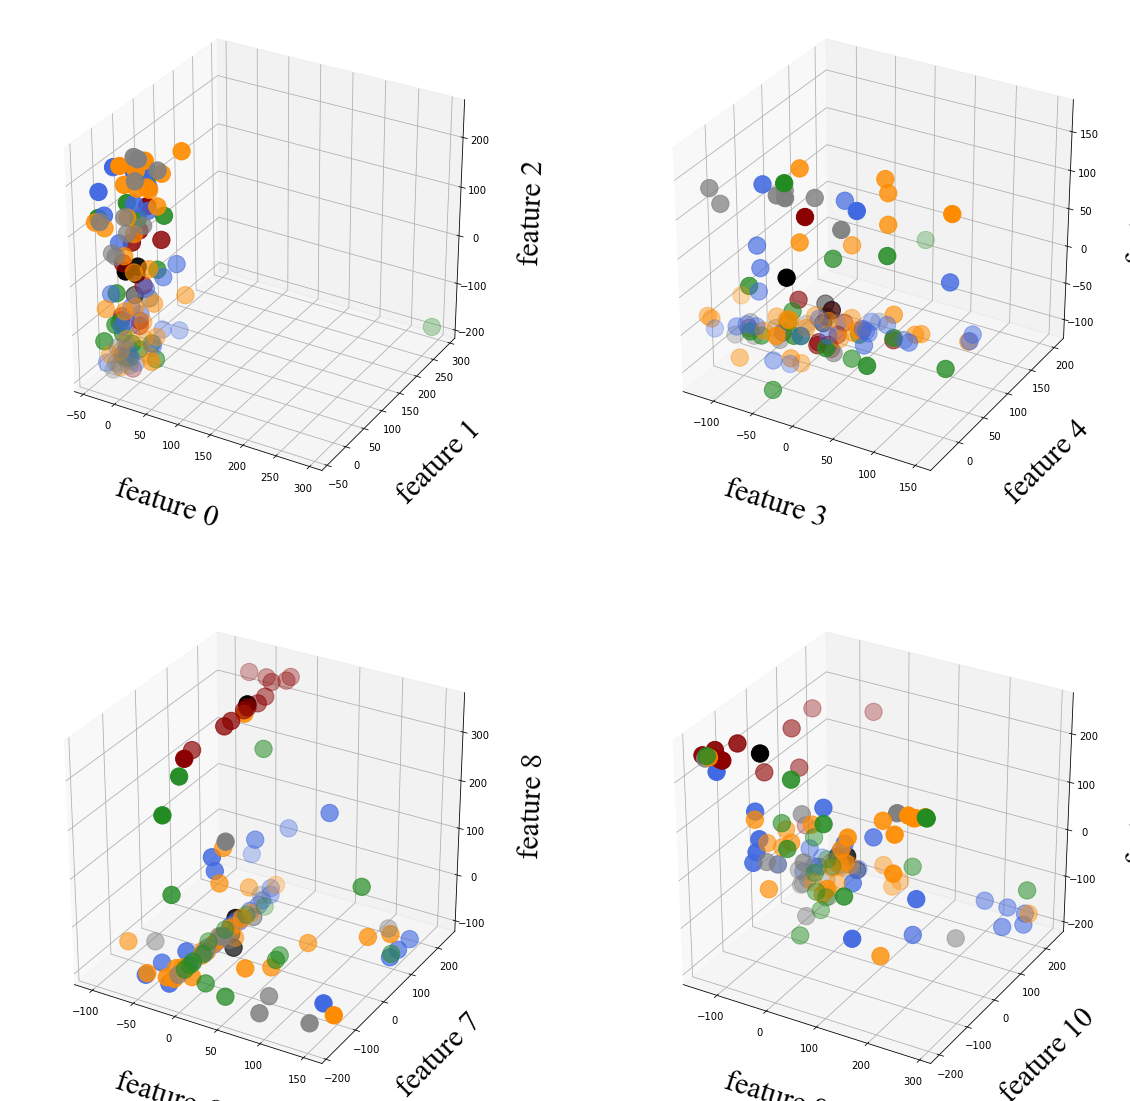

In [23]:
labelsize = 30
labelpad = 30
ticksize = 30
centersize = 300
aa = 0.5
colors = ['darkred','darkorange','forestgreen','royalblue', 'gray']

fig = plt.figure(figsize = (20,20))

ax = fig.add_subplot(221, projection='3d')
x = t_score[:,0] # feature 0
y = t_score[:,1] # feature 1
z = t_score[:,2] # feature 2
for lit in range(number_of_gaussian):
    ax.scatter(x[labels==lit],y[labels==lit],z[labels==lit],c=colors[lit],s = centersize)
x = centers[:,0]
y = centers[:,1]
z = centers[:,2]
ax.scatter(x,y,z,c='k',s = centersize)
ax.set_xlabel('feature 0',size = labelsize,labelpad = labelpad, fontname="Times New Roman")
ax.set_ylabel('feature 1',size = labelsize,labelpad = labelpad,fontname="Times New Roman")
ax.set_zlabel('feature 2',size = labelsize,labelpad = labelpad,fontname="Times New Roman")

ax = fig.add_subplot(222, projection='3d')
x = t_score[:,3] # feature 0
y = t_score[:,4] # feature 1
z = t_score[:,5] # feature 2
for lit in range(number_of_gaussian):
    ax.scatter(x[labels==lit],y[labels==lit],z[labels==lit],c=colors[lit],s = centersize)
x = centers[:,3]
y = centers[:,4]
z = centers[:,5]
ax.scatter(x,y,z,c='k',s = centersize)
ax.set_xlabel('feature 3',size = labelsize,labelpad = labelpad, fontname="Times New Roman")
ax.set_ylabel('feature 4',size = labelsize,labelpad = labelpad,fontname="Times New Roman")
ax.set_zlabel('feature 5',size = labelsize,labelpad = labelpad,fontname="Times New Roman")

ax = fig.add_subplot(223, projection='3d')
x = t_score[:,6] # feature 0
y = t_score[:,7] # feature 1
z = t_score[:,8] # feature 2
for lit in range(number_of_gaussian):
    ax.scatter(x[labels==lit],y[labels==lit],z[labels==lit],c=colors[lit],s = centersize)
x = centers[:,6]
y = centers[:,7]
z = centers[:,8]
ax.scatter(x,y,z,c='k',s = centersize)
ax.set_xlabel('feature 6',size = labelsize,labelpad = labelpad, fontname="Times New Roman")
ax.set_ylabel('feature 7',size = labelsize,labelpad = labelpad,fontname="Times New Roman")
ax.set_zlabel('feature 8',size = labelsize,labelpad = labelpad,fontname="Times New Roman")

ax = fig.add_subplot(224, projection='3d')
x = t_score[:,9] # feature 0
y = t_score[:,10] # feature 1
z = t_score[:,11] # feature 2
for lit in range(number_of_gaussian):
    ax.scatter(x[labels==lit],y[labels==lit],z[labels==lit],c=colors[lit],s = centersize)
x = centers[:,9]
y = centers[:,10]
z = centers[:,11]
ax.scatter(x,y,z,c='k',s = centersize)
ax.set_xlabel('feature 9',size = labelsize,labelpad = labelpad, fontname="Times New Roman")
ax.set_ylabel('feature 10',size = labelsize,labelpad = labelpad,fontname="Times New Roman")
ax.set_zlabel('feature 11',size = labelsize,labelpad = labelpad,fontname="Times New Roman")